# Surrogate Optimization

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

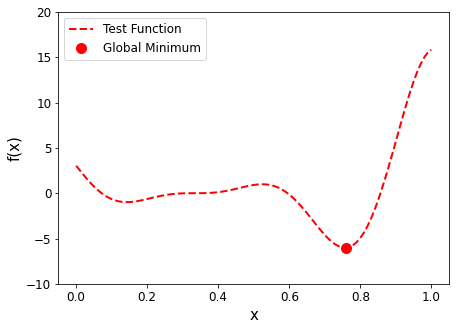

In [2]:
# Test function values
X_test = np.arange(0, 1.01, 0.01)
y_test = (X_test*6-2)**2*np.sin(X_test*12-4)

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

# Display global minimum
min_index = np.argmin(y_test)
ax.plot(X_test[min_index],y_test[min_index],'ro',markerfacecolor='r',markersize=10,label='Global Minimum')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12});
plt.savefig('Test_function.png')

In [3]:
# Initial training data
X_train = np.array([[0,0.1,0.2,0.4,0.6,1]]).T
y_train = (X_train*6-2)**2*np.sin(X_train*12-4)

In [4]:
# Train initial Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=1e-10, 
                                    normalize_y=True)
model.fit(X_train, y_train)

# GP prediction
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)

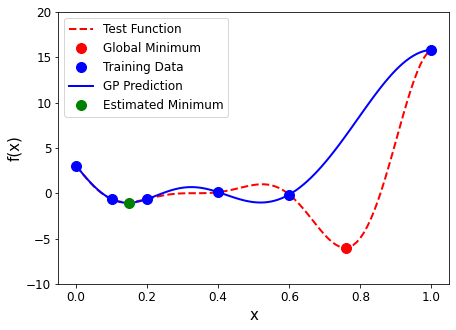

In [5]:
# Check GP prediction accuracy
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.tick_params(axis='both', which='major', labelsize=12)

# 1-Find the current minimum
index = np.argmin(y_pred)
current_location = X_test[index]
current_objective = y_pred[index]
ax.plot(current_location,current_objective,'go',
        markerfacecolor='g',markersize=10,label='Estimated Minimum');
ax.legend(loc="upper left",prop={'size': 12});
fig.savefig('Initial_training.png')
fig

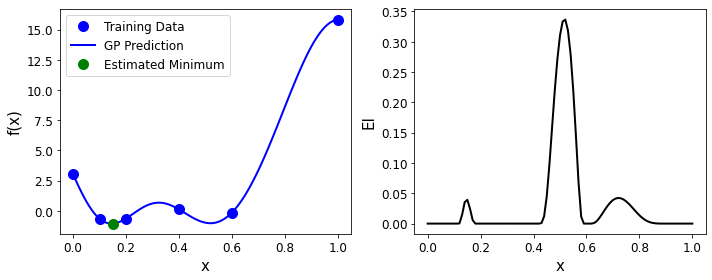

In [7]:
# Surrogate optimization based on Expected Improvement: EI visualization

# 2-Calculate expected improvement 
pred_std = pred_std.reshape(pred_std.shape[0], 1)
EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
        +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

# 3-Display EI distribution over the parameter space
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
axs[0].plot(X_test,y_pred+1.95*,'b--',linewidth=1.5,label='GP Prediction')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].plot(current_location,current_objective,'go',
        markerfacecolor='g',markersize=10,label='Estimated Minimum');
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_ylim([-10,20]);

axs[1].plot(X_test,EI,'k-',linewidth=2)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('EI', fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout();

In [235]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current minimum
    current_objective = y_pred[np.argmin(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)
    
    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI

In [236]:
# Surrogate optimization: iterations

# 0-Summarize current information
training_dataset = np.hstack((X_train,y_train))
candidates = np.arange(0, 1.01, 0.01)
iteration = 0

In [237]:
# 1-GP model training and predicting
model.fit(training_dataset[:,[0]], training_dataset[:,[1]])
y_pred, pred_std = model.predict(candidates.reshape((-1, 1)), return_std=True)

# 2-Calculate the current minimum
current_min = y_pred[np.argmin(y_pred),0]
location = candidates[np.argmin(y_pred)]

# 3-Select next sample
new_sample, EI = EI_learning(candidates, y_pred, pred_std)

# 4-Calculate the true label of the new sample
y_sample = (new_sample*6-2)**2*np.sin(new_sample*12-4)

# 5-Enrich training dataset
training_dataset = np.vstack((training_dataset,[new_sample,y_sample]))
iteration += 1

# 6-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'the current minimum is {}'.format(str(current_min)) \
                    + os.linesep \
                    + 'located at {}'.format(str(location))

print(Iteration_summary)

Iteration 1:
the current minimum is -1.061355182878347
located at 0.15


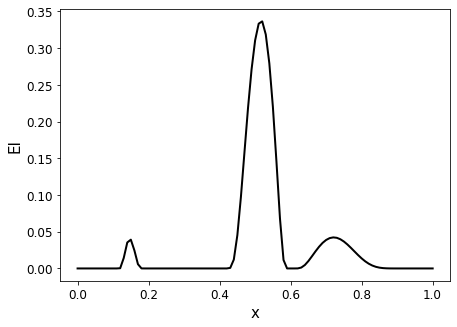

In [238]:
# Plot EI distribution
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(candidates,EI,'k-',linewidth=2)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('EI', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12);